In [141]:
import os
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,Activation,Conv2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix

from mpl_toolkits.axes_grid1 import ImageGrid

import itertools

from keras.callbacks import ModelCheckpoint

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Import OpenCV
import cv2

from os import listdir
from os.path import isfile, join 

from keras.callbacks import EarlyStopping

from keras import backend as K

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [142]:
# https://github.com/abhinav23dixit/Waste-Classification

# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

# plot image
# https://www.tensorflow.org/tutorials/images/classification
# https://github.com/msminhas93/KerasImageDatagenTutorial/blob/master/DataGenTutorial.ipynb

# confusion matrix
# https://www.kaggle.com/paoloripamonti/derma-diseases

# https://github.com/pranavmicro7/Garbage-classification/blob/master/using-cnn-test-accuracy-84.ipynb

In [143]:
base_dir = 'Recycling_Data_V1'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')
predict_dir = os.path.join(base_dir, 'Predict')

In [144]:
# ResNet50 image size
IMAGE_SIZE = (300,300)
INPUT_SHAPE = (300,300,3)

# Keras settings
TRAIN_BATCH_SIZE = 32
VALDATION_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

STEPS_PER_EPOCHS = 50
EPOCHS = 15
VALIDATION_STEPS = 228

LEARNING_RATE = 0.0001 

In [145]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [146]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,validation_split=0.1,rescale=1./255,
                         shear_range = 0.1,zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=TRAIN_BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=IMAGE_SIZE,
        batch_size=VALDATION_BATCH_SIZE,
        class_mode='categorical')


# Flow test images in batches of 20 using train_datagen generator
test_generator = test_datagen.flow_from_directory(
        directory=test_dir,  # This is the source directory for training images
        target_size=IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=TEST_BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        shuffle=False)


Found 1297 images belonging to 6 classes.
Found 630 images belonging to 6 classes.
Found 635 images belonging to 6 classes.


In [188]:
len(train_generator)

41

In [147]:
# classes training

train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [148]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}
class_mapping

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [149]:
type(class_mapping)

dict

In [150]:
x,y = next(train_generator) 
y_int = np.argmax(y,axis=-1)

## Plot Methods

In [151]:
def plot(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')
        

def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())
     
    plt.figure(figsize=(10,10))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

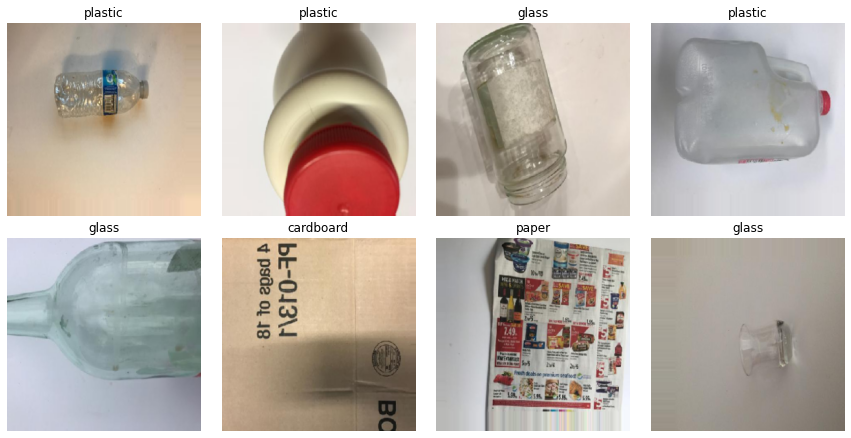

In [152]:
plot(x,2,4,label_list=y_int,show_labels=True,figsize=(15,10))

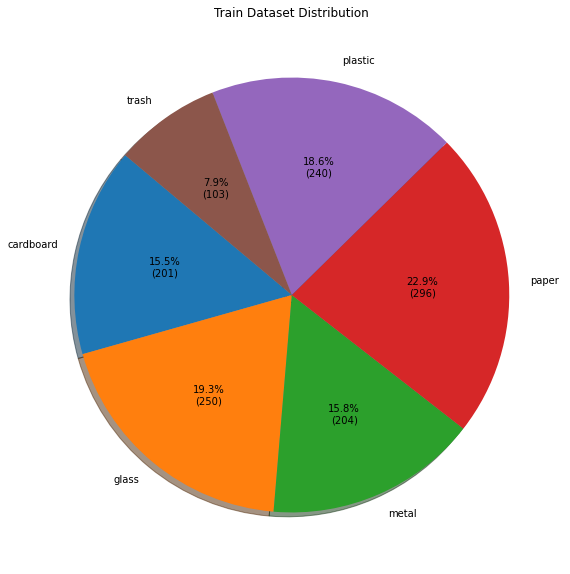

In [153]:
# Train dataset plot
plot_dataset(os.path.join(train_dir), "Train Dataset Distribution")


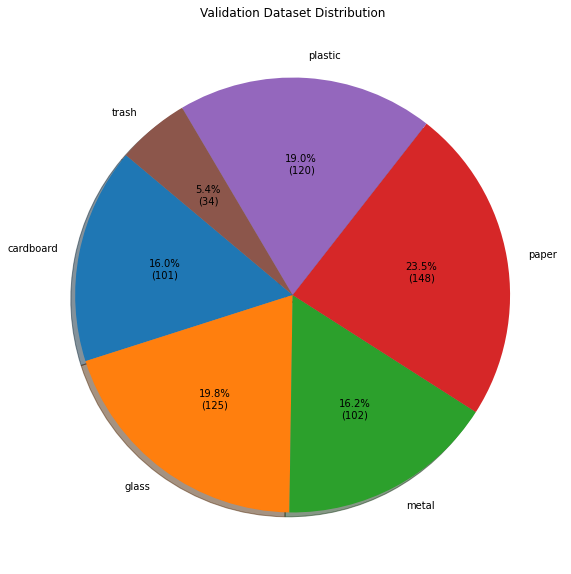

In [154]:
# Validation dataset plot
plot_dataset(os.path.join(validation_dir), "Validation Dataset Distribution")             

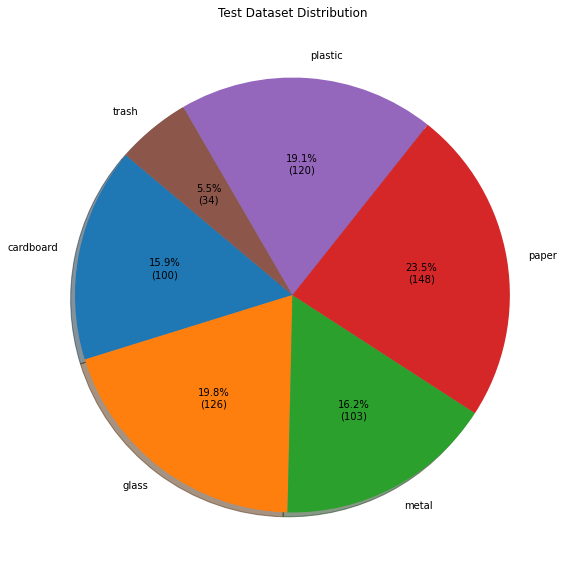

In [155]:
# Test dataset plot
plot_dataset(os.path.join(test_dir), "Test Dataset Distribution")

In [156]:
# Paper 1

## Model

In [157]:
classifier = Sequential()

classifier.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
classifier.add(MaxPooling2D(pool_size=2)) 
classifier.add(Conv2D(64,(3,3), padding='same',activation='relu'))
classifier.add(MaxPooling2D(pool_size=2)) 
classifier.add(Conv2D(32,(3,3), padding='same',activation='relu'))
classifier.add(MaxPooling2D(pool_size=2)) 
classifier.add(Flatten())
classifier.add(Dense(64,activation='relu'))
classifier.add(Dense(6,activation='softmax'))

In [158]:
classifier.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 43808)            

In [159]:
# classifier.add(Dense(output_dim=512,activation='relu'))
# classifier.add(Dense(output_dim=512,activation='relu')) 
# classifier.add(Dense(output_dim=6,activation='softmax'))

classifier.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# classifier.add(Flatten()) 

# classifier.add(Dense(output_dim=2048,activation='relu'))
# classifier.add(Dense(output_dim=2048,activation='relu'))
# classifier.add(Dense(output_dim=6,activation='softmax'))

# classifier.compile(optimizer='adam',
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy'])

In [160]:
# history=classifier.fit_generator(train_generator,
#                     steps_per_epoch=STEPS_PER_EPOCHS,
#                     epochs=EPOCHS,
#                     validation_data=validation_generator,
#                     validation_steps=VALIDATION_STEPS,callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

history=classifier.fit_generator(train_generator,
                    steps_per_epoch=1297//32 ,
                    epochs=100,
                    validation_data=validation_generator,validation_steps=630//32,
                    callbacks=callbacks_list)

Epoch 1/100
40/40 [==============================] - 102s 3s/step - loss: 1.7972 - accuracy: 0.2032 - val_loss: 1.5481 - val_accuracy: 0.2697
Epoch 2/100
40/40 [==============================] - 93s 2s/step - loss: 1.6207 - accuracy: 0.3249 - val_loss: 1.5320 - val_accuracy: 0.3946
Epoch 3/100
40/40 [==============================] - 93s 2s/step - loss: 1.5215 - accuracy: 0.3842 - val_loss: 1.3936 - val_accuracy: 0.4181
Epoch 4/100
40/40 [==============================] - 96s 2s/step - loss: 1.3758 - accuracy: 0.4594 - val_loss: 1.4469 - val_accuracy: 0.4916
Epoch 5/100
40/40 [==============================] - 94s 2s/step - loss: 1.3680 - accuracy: 0.4648 - val_loss: 1.2195 - val_accuracy: 0.4900
Epoch 6/100
40/40 [==============================] - 93s 2s/step - loss: 1.2638 - accuracy: 0.5156 - val_loss: 1.0480 - val_accuracy: 0.5385
Epoch 7/100
40/40 [==============================] - 96s 2s/step - loss: 1.2297 - accuracy: 0.5352 - val_loss: 1.4792 - val_accuracy: 0.5435
Epoch 8/100


40/40 [==============================] - 125s 3s/step - loss: 0.5620 - accuracy: 0.8040 - val_loss: 1.0133 - val_accuracy: 0.6839
Epoch 59/100
40/40 [==============================] - 124s 3s/step - loss: 0.4668 - accuracy: 0.8403 - val_loss: 0.2461 - val_accuracy: 0.7358
Epoch 60/100
40/40 [==============================] - 132s 3s/step - loss: 0.4756 - accuracy: 0.8344 - val_loss: 1.2770 - val_accuracy: 0.6890
Epoch 61/100
40/40 [==============================] - 134s 3s/step - loss: 0.4816 - accuracy: 0.8332 - val_loss: 1.1626 - val_accuracy: 0.6793
Epoch 62/100
40/40 [==============================] - 134s 3s/step - loss: 0.4720 - accuracy: 0.8229 - val_loss: 0.9102 - val_accuracy: 0.7074
Epoch 63/100
40/40 [==============================] - 123s 3s/step - loss: 0.4695 - accuracy: 0.8384 - val_loss: 0.8029 - val_accuracy: 0.7258
Epoch 64/100
40/40 [==============================] - 122s 3s/step - loss: 0.4325 - accuracy: 0.8469 - val_loss: 1.0780 - val_accuracy: 0.7090
Epoch 65/100

In [161]:
# Performance matrix 
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

val_loss  val_accuracy      loss  accuracy  epoch
0   1.548054      0.269737  1.797956  0.203162      0
1   1.531998      0.394649  1.620305  0.324901      1
2   1.393570      0.418060  1.522872  0.384190      2
3   1.446870      0.491639  1.375814  0.459375      3
4   1.219480      0.489967  1.363771  0.464800      4
..       ...           ...       ...       ...    ...
95  0.877786      0.719064  0.411681  0.854688     95
96  0.918747      0.737458  0.316180  0.884585     96
97  1.049094      0.714047  0.330602  0.887747     97
98  0.837908      0.715719  0.312975  0.883200     98
99  0.516047      0.747492  0.294407  0.884375     99

[100 rows x 5 columns]

## Training and Validation dataset performance

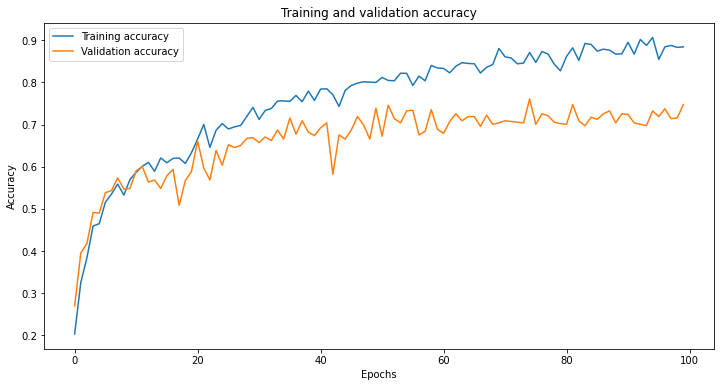

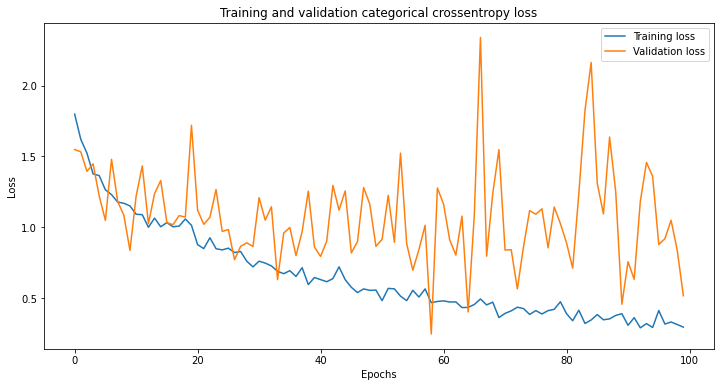

In [162]:
# Graph: Training and Validation dataset performance

plt.rcParams['figure.figsize'] = (12.0, 6.0)

def plot_cnn_performance(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and validation categorical crossentropy loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_cnn_performance(history)

In [163]:
#Evaluate model performance on validation dataset

score = classifier.evaluate_generator(validation_generator)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.8549473285675049
Validation accuracy: 0.7460317611694336


In [164]:
#Evaluate model performance on training dataset

score = classifier.evaluate_generator(train_generator)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.46932876110076904
Train accuracy: 0.9205859899520874


In [165]:
loss, accuracy = classifier.evaluate_generator(test_generator,
            steps=test_generator.samples//test_generator.batch_size)

In [166]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))

Accuracy: 0.773026
Loss: 1.130346


In [167]:
predict=classifier.predict_generator(test_generator)

In [168]:
y_pred = np.argmax(predict, axis=1)

In [169]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)
cnf_matrix

array([[ 84,   2,   2,   6,   5,   2],
       [  3,  89,  13,   1,  18,   2],
       [  2,  12,  75,   3,   4,   7],
       [  1,   5,   6, 124,   6,   7],
       [  3,   7,   8,   6,  91,   6],
       [  0,   2,   0,   0,   0,  33]], dtype=int64)

In [170]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

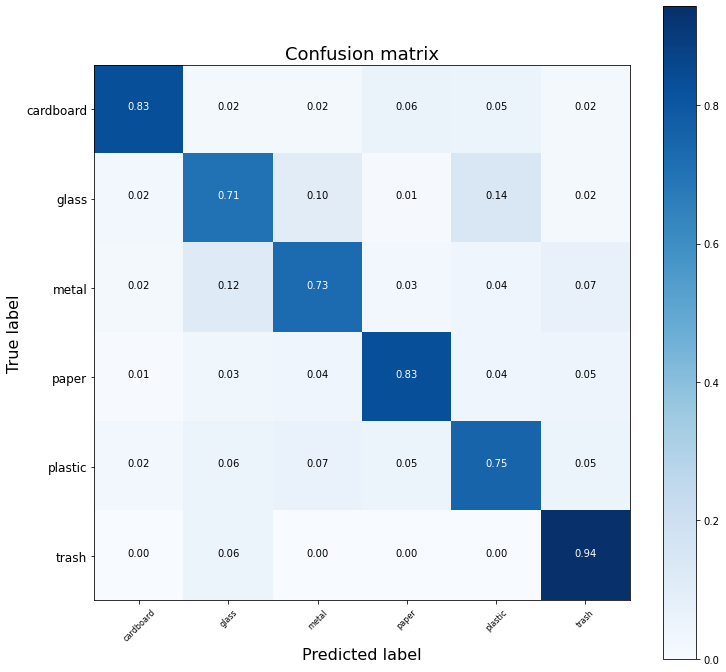

In [171]:
plot_confusion_matrix(cnf_matrix, list(class_mapping.values()))

In [172]:
print(classification_report(test_generator.classes, y_pred, target_names=list(class_mapping.values())))

              precision    recall  f1-score   support

   cardboard       0.90      0.83      0.87       101
       glass       0.76      0.71      0.73       126
       metal       0.72      0.73      0.72       103
       paper       0.89      0.83      0.86       149
     plastic       0.73      0.75      0.74       121
       trash       0.58      0.94      0.72        35

    accuracy                           0.78       635
   macro avg       0.76      0.80      0.77       635
weighted avg       0.79      0.78      0.78       635



## Predict New Images

In [186]:
def load_image(filename):
    img = cv2.imread(os.path.join(predict_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255    
    return img

def predict(image):
    probabilities = classifier.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)    
    return {class_mapping[class_idx]: probabilities[class_idx]}

In [184]:
# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]

Image Name -  glass107.jpg
[[3.6040572e-05 3.4782894e-05 4.4213757e-02 9.4192964e-01 1.3317539e-02
  4.6818159e-04]]
[3.6040572e-05 3.4782894e-05 4.4213757e-02 9.4192964e-01 1.3317539e-02
 4.6818159e-04]
Predicted Class - class: paper, Predicted Confidence: 0.941930


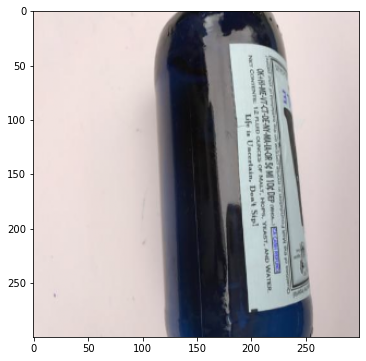

Image Name -  glass32.jpg
[[1.3508366e-03 9.7321987e-02 4.7584400e-03 7.3387841e-04 8.9477414e-01
  1.0606576e-03]]
[1.3508366e-03 9.7321987e-02 4.7584400e-03 7.3387841e-04 8.9477414e-01
 1.0606576e-03]
Predicted Class - class: plastic, Predicted Confidence: 0.894774


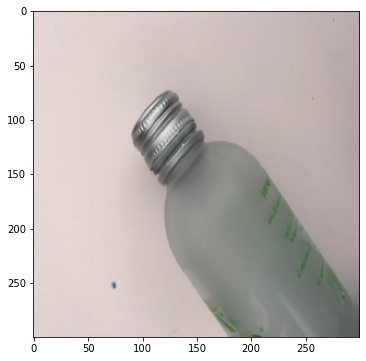

Image Name -  metal182.jpg
[[1.1015559e-04 1.2874231e-06 2.2924267e-02 2.0911322e-09 9.7654736e-01
  4.1696563e-04]]
[1.1015559e-04 1.2874231e-06 2.2924267e-02 2.0911322e-09 9.7654736e-01
 4.1696563e-04]
Predicted Class - class: plastic, Predicted Confidence: 0.976547


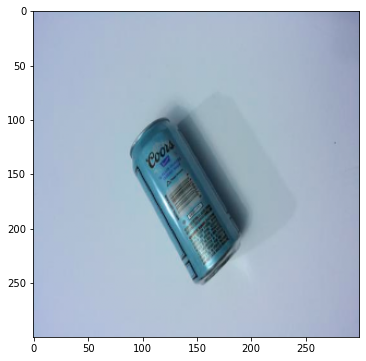

Image Name -  metal223.jpg
[[2.3305731e-06 5.3934180e-03 9.3738180e-01 2.7780128e-03 5.4363728e-02
  8.0800877e-05]]
[2.3305731e-06 5.3934180e-03 9.3738180e-01 2.7780128e-03 5.4363728e-02
 8.0800877e-05]
Predicted Class - class: metal, Predicted Confidence: 0.937382


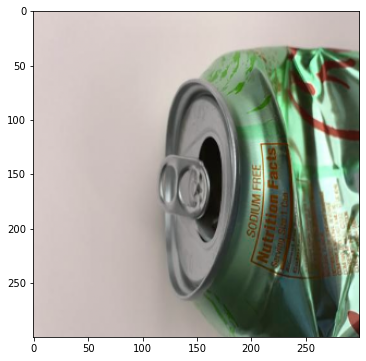

Image Name -  metal81.jpg
[[1.0000000e+00 5.2097308e-37 2.8687408e-11 4.8189657e-15 2.2896807e-20
  2.9251572e-24]]
[1.0000000e+00 5.2097308e-37 2.8687408e-11 4.8189657e-15 2.2896807e-20
 2.9251572e-24]
Predicted Class - class: cardboard, Predicted Confidence: 1.000000


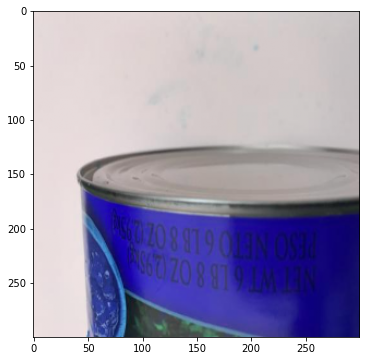

Image Name -  metal97.jpg
[[4.9680392e-07 2.2448312e-06 2.3078802e-01 7.6490772e-01 4.2339494e-03
  6.7576999e-05]]
[4.9680392e-07 2.2448312e-06 2.3078802e-01 7.6490772e-01 4.2339494e-03
 6.7576999e-05]
Predicted Class - class: paper, Predicted Confidence: 0.764908


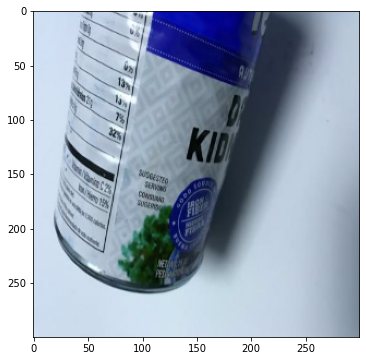

Image Name -  plastic166.jpg
[[1.0353195e-02 2.5894022e-01 1.6030502e-03 1.6478771e-04 7.2890037e-01
  3.8437352e-05]]
[1.0353195e-02 2.5894022e-01 1.6030502e-03 1.6478771e-04 7.2890037e-01
 3.8437352e-05]
Predicted Class - class: plastic, Predicted Confidence: 0.728900


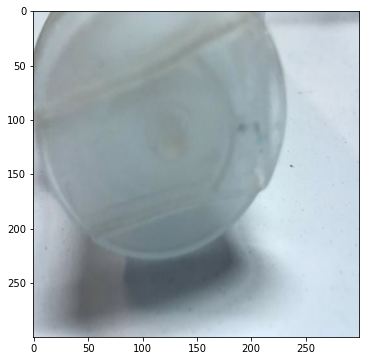

Image Name -  plastic172.jpg
[[1.1549748e-03 4.0256973e-02 5.9746062e-06 8.3172654e-06 9.5852697e-01
  4.6841295e-05]]
[1.1549748e-03 4.0256973e-02 5.9746062e-06 8.3172654e-06 9.5852697e-01
 4.6841295e-05]
Predicted Class - class: plastic, Predicted Confidence: 0.958527


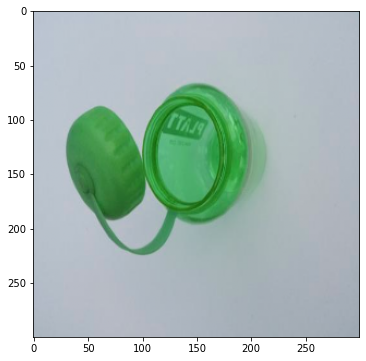

Image Name -  plastic209.jpg
[[1.0787395e-05 1.6150539e-01 8.1587005e-01 1.4351761e-04 4.2246063e-03
  1.8245593e-02]]
[1.0787395e-05 1.6150539e-01 8.1587005e-01 1.4351761e-04 4.2246063e-03
 1.8245593e-02]
Predicted Class - class: metal, Predicted Confidence: 0.815870


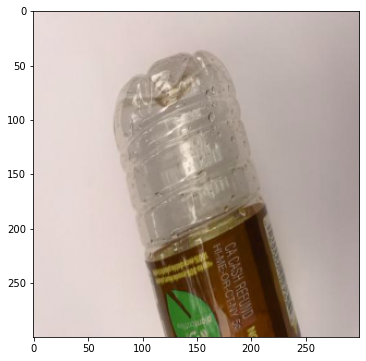

Image Name -  plastic218.jpg
[[3.3286586e-05 3.9328158e-02 8.9822721e-01 1.2564544e-05 6.2396374e-02
  2.4328042e-06]]
[3.3286586e-05 3.9328158e-02 8.9822721e-01 1.2564544e-05 6.2396374e-02
 2.4328042e-06]
Predicted Class - class: metal, Predicted Confidence: 0.898227


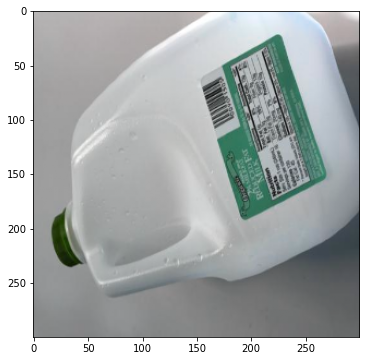

Image Name -  plastic449.jpg
[[5.4196676e-04 1.0115022e-03 1.3368209e-01 1.6639264e-06 8.6459816e-01
  1.6460866e-04]]
[5.4196676e-04 1.0115022e-03 1.3368209e-01 1.6639264e-06 8.6459816e-01
 1.6460866e-04]
Predicted Class - class: plastic, Predicted Confidence: 0.864598


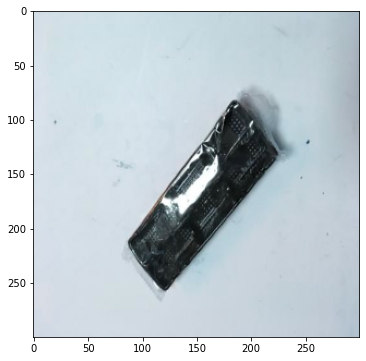

Image Name -  plastic453.jpg
[[2.7366958e-03 4.9682520e-02 5.2746415e-01 2.6671717e-06 4.2011219e-01
  1.8241722e-06]]
[2.7366958e-03 4.9682520e-02 5.2746415e-01 2.6671717e-06 4.2011219e-01
 1.8241722e-06]
Predicted Class - class: metal, Predicted Confidence: 0.527464


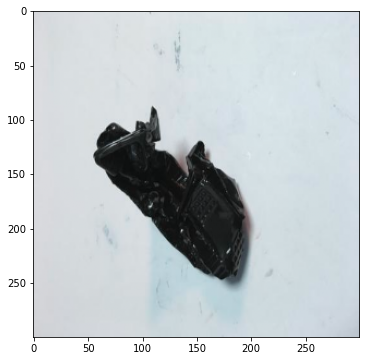

Image Name -  trash10.jpg
[[1.6782567e-04 1.6547526e-06 1.2228279e-04 4.9438426e-11 9.9503434e-01
  4.6738591e-03]]
[1.6782567e-04 1.6547526e-06 1.2228279e-04 4.9438426e-11 9.9503434e-01
 4.6738591e-03]
Predicted Class - class: plastic, Predicted Confidence: 0.995034


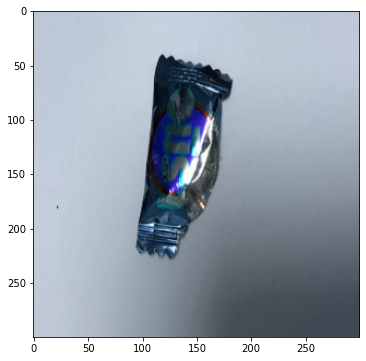

Image Name -  trash102.jpg
[[5.0338816e-10 9.9105549e-01 8.2839579e-05 6.1402510e-08 8.8611552e-03
  3.8072113e-07]]
[5.0338816e-10 9.9105549e-01 8.2839579e-05 6.1402510e-08 8.8611552e-03
 3.8072113e-07]
Predicted Class - class: glass, Predicted Confidence: 0.991055


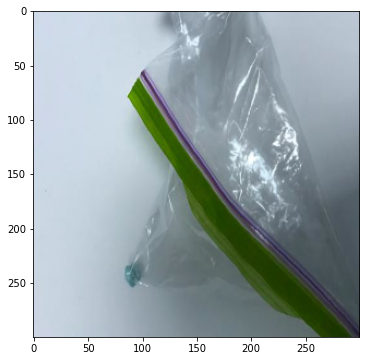

Image Name -  trash109.jpg
[[1.0269951e-08 1.3595093e-07 5.6754109e-03 3.0754725e-07 9.9432409e-01
  8.9686594e-08]]
[1.0269951e-08 1.3595093e-07 5.6754109e-03 3.0754725e-07 9.9432409e-01
 8.9686594e-08]
Predicted Class - class: plastic, Predicted Confidence: 0.994324


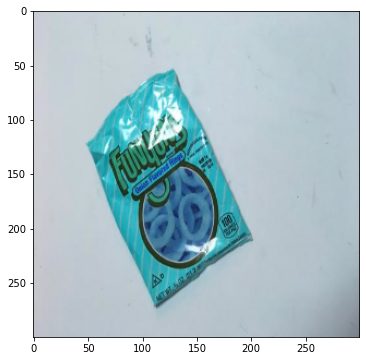

Image Name -  trash118.jpg
[[4.2770207e-05 1.2184888e-04 2.8790174e-02 8.0554548e-07 9.7074360e-01
  3.0073736e-04]]
[4.2770207e-05 1.2184888e-04 2.8790174e-02 8.0554548e-07 9.7074360e-01
 3.0073736e-04]
Predicted Class - class: plastic, Predicted Confidence: 0.970744


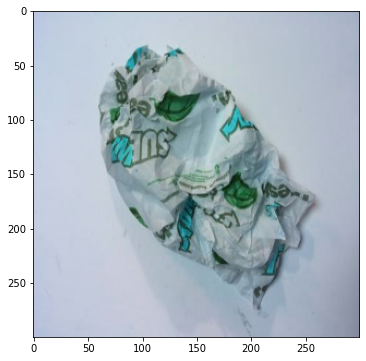

Image Name -  trash15.jpg
[[5.9589569e-11 1.3656047e-13 1.5140601e-01 2.9635046e-08 8.4859383e-01
  1.1338735e-07]]
[5.9589569e-11 1.3656047e-13 1.5140601e-01 2.9635046e-08 8.4859383e-01
 1.1338735e-07]
Predicted Class - class: plastic, Predicted Confidence: 0.848594


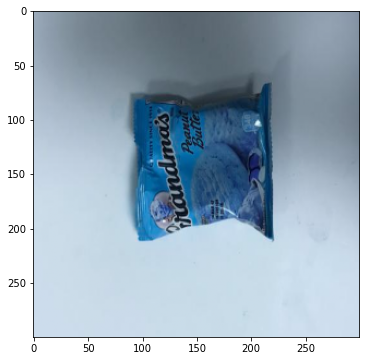

Image Name -  trash60.jpg
[[7.7472485e-08 2.3548559e-05 1.2631806e-05 1.3271623e-10 9.9996328e-01
  4.9077909e-07]]
[7.7472485e-08 2.3548559e-05 1.2631806e-05 1.3271623e-10 9.9996328e-01
 4.9077909e-07]
Predicted Class - class: plastic, Predicted Confidence: 0.999963


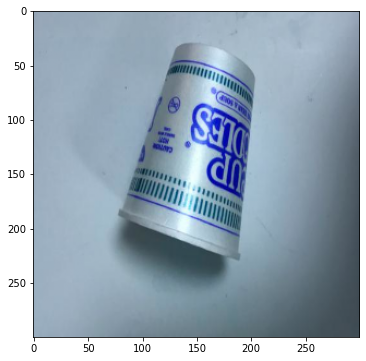

Image Name -  trash8.jpg
[[2.2066010e-06 4.1329649e-06 5.0566988e-03 2.1146687e-05 9.9491584e-01
  3.2197997e-10]]
[2.2066010e-06 4.1329649e-06 5.0566988e-03 2.1146687e-05 9.9491584e-01
 3.2197997e-10]
Predicted Class - class: plastic, Predicted Confidence: 0.994916


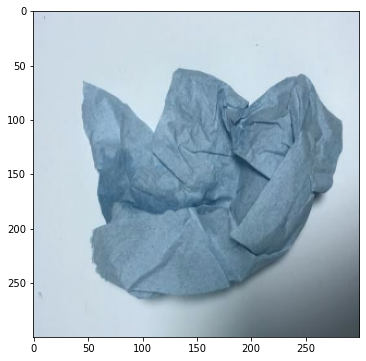

In [185]:
# load image path to predict
# onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]


for image_file in onlyfiles:
    print("Image Name - ", image_file);
    img = load_image(image_file)
    prediction = predict(img)
    print("Predicted Class - class: %s, Predicted Confidence: %f" 
          % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)  
    plt.show()    
    

In [176]:
classifier.save('model_test_v1.h5')

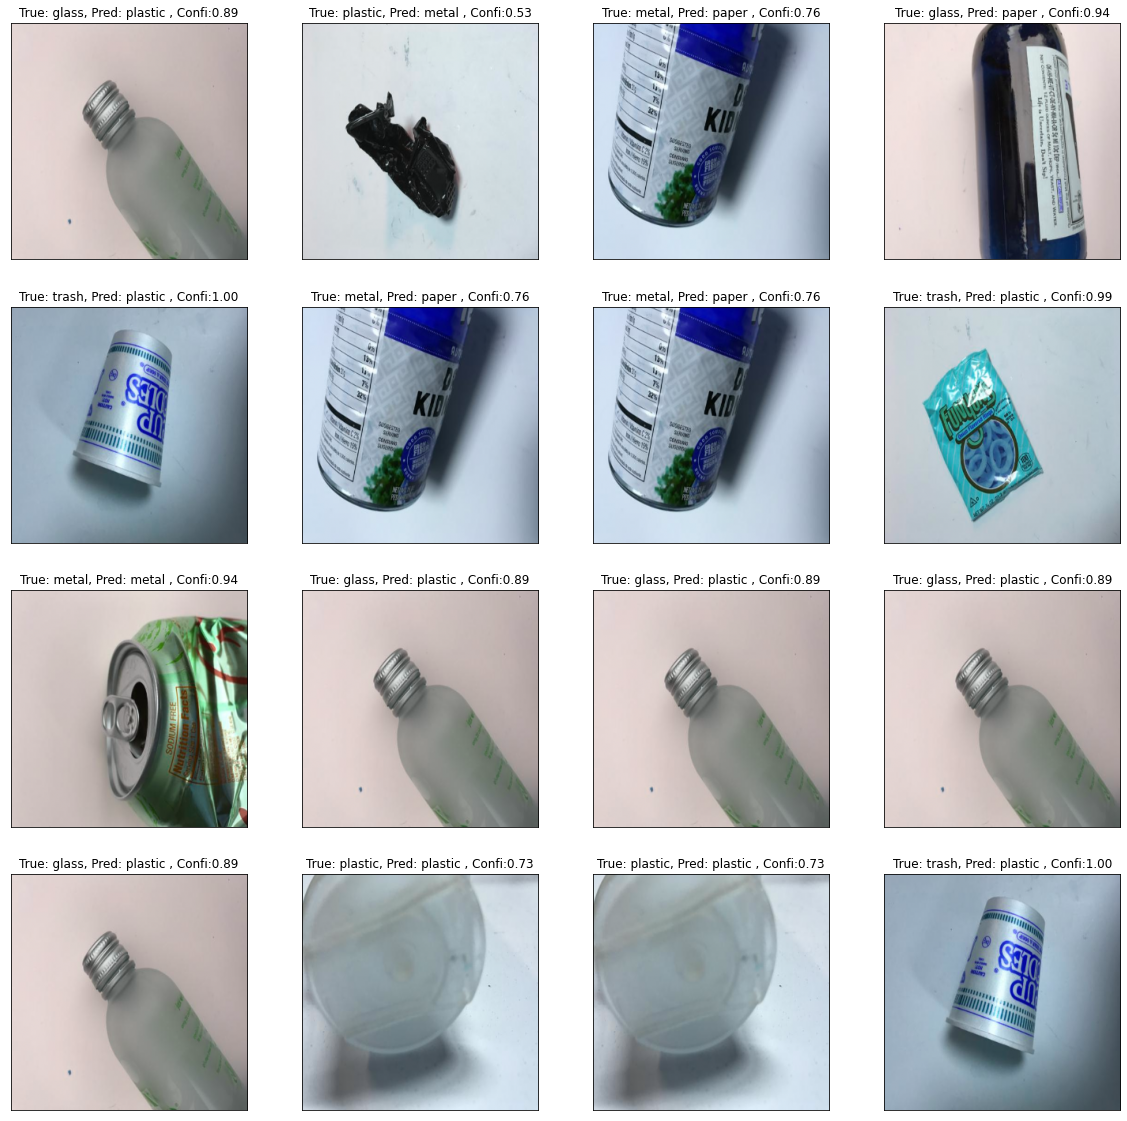

In [177]:
# Plot function 

def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    elif "trash" in filename:
        return 'trash'

def plot_predicted_label_1(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 20))
    
    rs = np.random.choice(len(onlyfiles), nrows*ncols)
    
    for i, ax in zip(rs, axes.flat):
        img = load_image(onlyfiles[i])
        true_type = image_type(onlyfiles[i])
        prediction = predict(img)
     
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,list(prediction.keys())[0],list(prediction.values())[0])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])
        
# ploat image with predicted and actual value
num_rows = 4
num_cols = 4
plot_predicted_label_1(num_rows, num_cols,onlyfiles);

In [178]:
# import pickle

In [179]:
# model_path =  "../WasteSortingApp/waste_image_classifier.pk"
# pickle.dump(classifier, open(model_path,"wb"))